In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#mengimport package

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import seaborn as sns
from datetime import datetime
from time import time

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sa
import statsmodels.formula.api as sm
%matplotlib inline



In [ ]:
customer = pd.read_csv('/content/drive/MyDrive/MODUL 4 PYTHON/PRAKTIK MANDIRI 2/customer_data.csv')
laptop = pd.read_csv('/content/drive/MyDrive/MODUL 4 PYTHON/PRAKTIK MANDIRI 2/Salinan laptop_data.csv')

customer.head(5)

,ID,Year_Birth,Education,Income,Dt_Customer,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,Graduation,58138.0,9/4/2012,58,8,4,7
1,2174,1954,Graduation,46344.0,3/8/2014,38,1,2,5
2,4141,1965,Graduation,71613.0,8/21/2013,26,8,10,4
3,6182,1984,Graduation,26646.0,2/10/2014,26,2,4,6
4,5324,1981,PhD,58293.0,1/19/2014,94,5,6,5


#Proses Cleaning

## Dataset Customer

In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2240 non-null   int64  
 1   Year_Birth         2240 non-null   int64  
 2   Education          2240 non-null   object 
 3   Income             2216 non-null   float64
 4   Dt_Customer        2240 non-null   object 
 5   Recency            2240 non-null   int64  
 6   NumWebPurchases    2240 non-null   int64  
 7   NumStorePurchases  2240 non-null   int64  
 8   NumWebVisitsMonth  2240 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 157.6+ KB


In [ ]:
#mengubah tipe data dari Dt_Customer yang sebelumnya Objek menjadi Datetime
customer['Dt_Customer']= pd.to_datetime(customer['Dt_Customer'])
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 2240 non-null   int64         
 1   Year_Birth         2240 non-null   int64         
 2   Education          2240 non-null   object        
 3   Income             2216 non-null   float64       
 4   Dt_Customer        2240 non-null   datetime64[ns]
 5   Recency            2240 non-null   int64         
 6   NumWebPurchases    2240 non-null   int64         
 7   NumStorePurchases  2240 non-null   int64         
 8   NumWebVisitsMonth  2240 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 157.6+ KB


In [ ]:
#cek data yang kosong dan ditemukan data yang kosong pada kolom income
customer.isnull().sum()

ID                    0
Year_Birth            0
Education             0
Income               24
Dt_Customer           0
Recency               0
NumWebPurchases       0
NumStorePurchases     0
NumWebVisitsMonth     0
dtype: int64

In [ ]:
#cek informassi pada kolom Income
customer.Income.describe()


count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [ ]:
#Mengisi data Income yang kosong dengan median data karena aman dari Outlier
customer.fillna({'Income': 51381.5}, inplace = True)


In [ ]:
#cek kembali kolom yang kosong pada data
customer.isnull().sum()

ID                   0
Year_Birth           0
Education            0
Income               0
Dt_Customer          0
Recency              0
NumWebPurchases      0
NumStorePurchases    0
NumWebVisitsMonth    0
dtype: int64

## cek duplikat


In [ ]:
# mengecek data duplikat yang ada pada dataset
print(f" ada {customer.duplicated().sum()} baris duplikat")

 ada 0 baris duplikat


##cek Outlier

<Axes: >

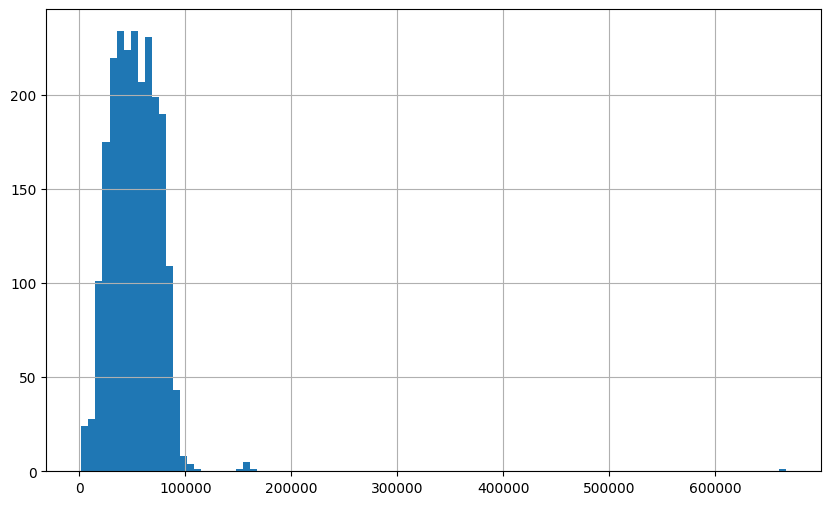

In [ ]:
#menggambarkan data Income dengan histogram
plt.figure(figsize=(10,6))
customer['Income'].hist(bins=100)

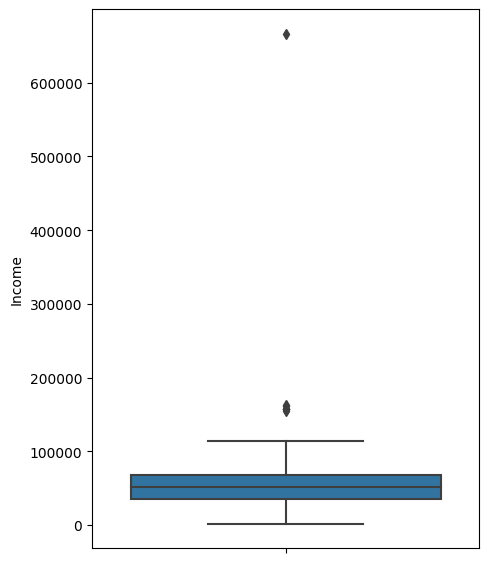

In [ ]:
#cek visualisasi kolom Income dengan Boxplot

plt.figure(figsize = (5,7))
sns.boxplot(y='Income',data = customer)
plt.show()

In [ ]:
#IQR

# membuat sebuah fungsi untuk mengecek Outlier
def cek_outlier(nama_kolom, batas):
  Q1 = np.percentile(customer[nama_kolom], 25,
                     interpolation = 'midpoint')

  Q3 = np.percentile(customer[nama_kolom], 75,
                     interpolation = 'midpoint')

  IQR = Q3 - Q1

#Menentukan Upper Bound
  if batas == 'upper_bound':
      bound = np.where(customer[nama_kolom] >= (Q3 + 1.5*IQR))

#menentukan Lower Bound
  elif batas == 'lower_bound':
      bound = np.where(customer[nama_kolom] <= (Q1 - 1.5*IQR))
  return list(bound[0])

In [ ]:
#menerapkan fungsi yang telah dibuat untuk mengecek outlier pada kolom Income

Upper_Income = cek_outlier('Income','upper_bound')
Lower_Income = cek_outlier('Income','lower_bound')
print(f"total outlier dikolom Income adalah {len(Upper_Income) + len(Lower_Income)}")

total outlier dikolom Income adalah 8


In [ ]:
#karena jumlahnya yang sedikit, saya memutuskan untuk mengganti Outlier dengan Median data saja

def inputasi_outlier(df):
  Q1=df.quantile(0.25)
  Q3=df.quantile(0.75)
  IQR = Q3-Q1

  upper = df[~(df>(Q3+1.5*IQR))].max()
  lower = df[~(df<(Q1-1.5*IQR))].min()

  df = np.where(df > upper,

                df.median(),

                np.where(

                    df < lower,

                    df.median() ,

                    df
                      )
                )
  return df

In [ ]:
#Membuat kolom baru untuk menampung data Income terbaru
#Menggunakan Function yang telah dibuat sebelumnya untuk mengganti data Outlier

customer['Income2'] = inputasi_outlier(customer['Income'])

In [ ]:
#membuang Kolom Income yang berisi data Lama

customer = customer.drop('Income',axis =1)

In [ ]:
#mengubah nama kolom Income2 menjadi Income

customer= customer.rename(columns={'Income2': 'Income'})

In [ ]:
customer.head()

,ID,Year_Birth,Education,Dt_Customer,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income
0,5524,1957,Graduation,2012-09-04,58,8,4,7,58138.0
1,2174,1954,Graduation,2014-03-08,38,1,2,5,46344.0
2,4141,1965,Graduation,2013-08-21,26,8,10,4,71613.0
3,6182,1984,Graduation,2014-02-10,26,2,4,6,26646.0
4,5324,1981,PhD,2014-01-19,94,5,6,5,58293.0


<Axes: >

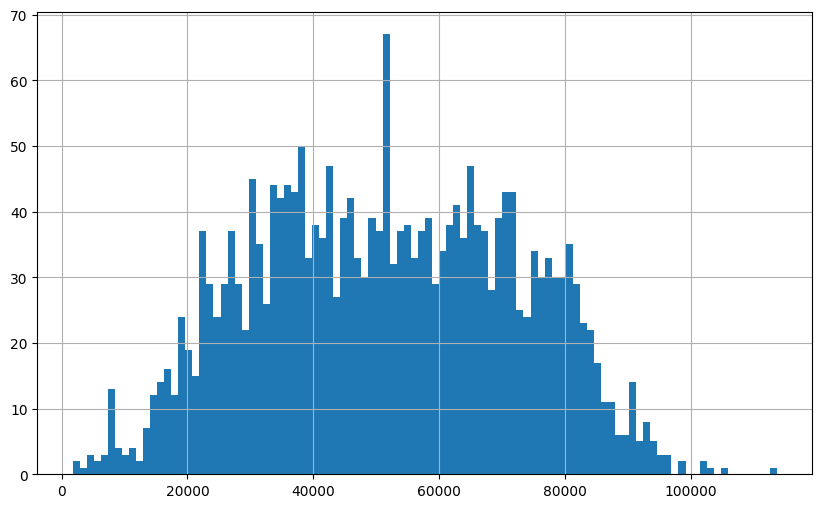

In [ ]:
# Cek visualisasi data income dengan Histogram

plt.figure(figsize=(10,6))
customer['Income'].hist(bins=100)

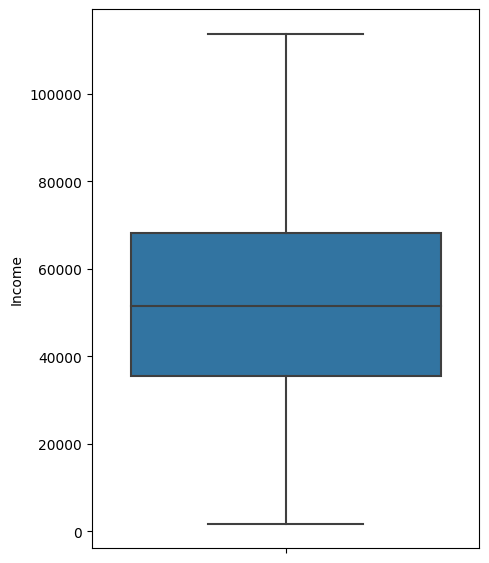

In [ ]:
# mengecek kembali data Income dengan menggunakan Boxplot

plt.figure(figsize = (5,7))
sns.boxplot(y='Income',data = customer)
plt.show()

In [ ]:
customer.head(5)

,ID,Year_Birth,Education,Dt_Customer,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income
0,5524,1957,Graduation,2012-09-04,58,8,4,7,58138.0
1,2174,1954,Graduation,2014-03-08,38,1,2,5,46344.0
2,4141,1965,Graduation,2013-08-21,26,8,10,4,71613.0
3,6182,1984,Graduation,2014-02-10,26,2,4,6,26646.0
4,5324,1981,PhD,2014-01-19,94,5,6,5,58293.0


## a. Membuat segmentasi atau Cluster pelanggan


### i & ii


In [ ]:
#Mengubah nama Kolom Dt_Customer menjadi Years_Since_Registration & Hitung selisih tahun antara tahun sekarang dan 'Dt_Customer' untuk mengisi Year_since_registration
#Mengubah nama Kolom Year_Birth menjadi Age

Tahun_Sekarang = datetime.now().year
customer['Years_Since_Registration'] = Tahun_Sekarang - customer['Dt_Customer'].dt.year

#Membuat Kolom Age yang berisi umur pelanggan pada tahun sekarang

customer['Age'] = Tahun_Sekarang- customer['Year_Birth']



In [ ]:
#hapus kolom Dt_Customer & Year_Birth

customer = customer.drop('Dt_Customer',axis=1)
customer = customer.drop('Year_Birth',axis=1)

In [ ]:
customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,58,8,4,7,58138.0,11,66
1,2174,Graduation,38,1,2,5,46344.0,9,69
2,4141,Graduation,26,8,10,4,71613.0,10,58
3,6182,Graduation,26,2,4,6,26646.0,9,39
4,5324,PhD,94,5,6,5,58293.0,9,42


<ipython-input-26-be36e45bf6d0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['Income'])


<Axes: xlabel='Income', ylabel='Density'>

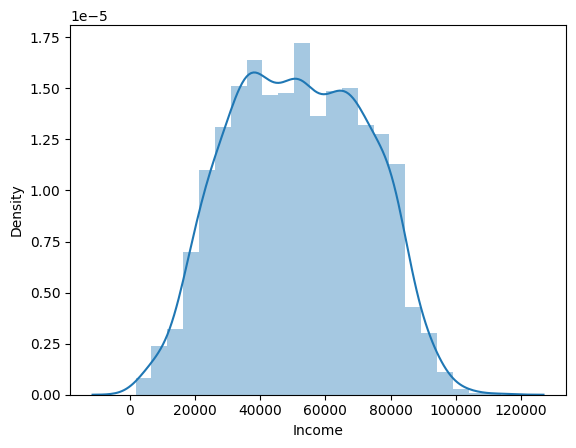

In [ ]:
sns.distplot(customer['Income'])

In [ ]:
# Mengubah data Income menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data
# memakai Fungsi pd.cut() untuk membagi data numerik ke dalam beberapa kelompok berdasarkan nilainya.
# bins digunakan untuk menentukan batas-batas dari setiap kelompok.
# labels digunakan untuk memberikan label untuk setiap kelompok yang ada.

customer['Income'] = pd.cut(customer['Income'], bins=[0, 20000, 40000, 60000,80000,100000,120000,130000], labels=['0 - 19999', '20000 - 39999', '40000 - 59999', '60000 - 79999', '80000 - 99999','100000 - 119999' , '120000+'])

In [ ]:
customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,58,8,4,7,40000 - 59999,11,66
1,2174,Graduation,38,1,2,5,40000 - 59999,9,69
2,4141,Graduation,26,8,10,4,60000 - 79999,10,58
3,6182,Graduation,26,2,4,6,20000 - 39999,9,39
4,5324,PhD,94,5,6,5,40000 - 59999,9,42


<ipython-input-29-8d100dfab1d6>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['Age'])


<Axes: xlabel='Age', ylabel='Density'>

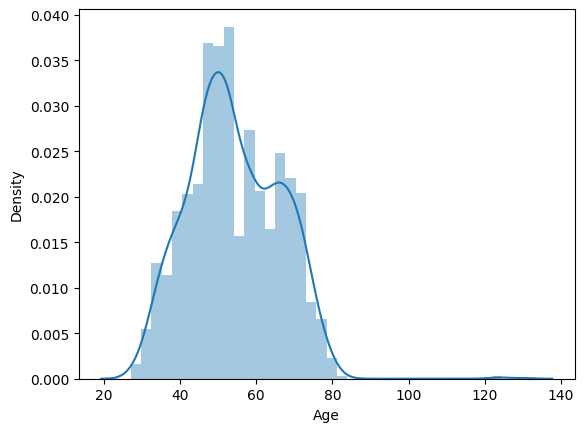

In [ ]:
#cek visualisasi data Age

sns.distplot(customer['Age'])

In [ ]:
##Mengubah data Age menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data

customer['Age'] = pd.cut(customer['Age'], bins=[20,40,60,80,100,120,140], labels=['20 - 39', '40 - 59', '60 - 79','80 - 99', '100 - 119', '120+'])

In [ ]:
customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,58,8,4,7,40000 - 59999,11,60 - 79
1,2174,Graduation,38,1,2,5,40000 - 59999,9,60 - 79
2,4141,Graduation,26,8,10,4,60000 - 79999,10,40 - 59
3,6182,Graduation,26,2,4,6,20000 - 39999,9,20 - 39
4,5324,PhD,94,5,6,5,40000 - 59999,9,40 - 59


<ipython-input-32-fb4127a6bc3d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['Recency'])


<Axes: xlabel='Recency', ylabel='Density'>

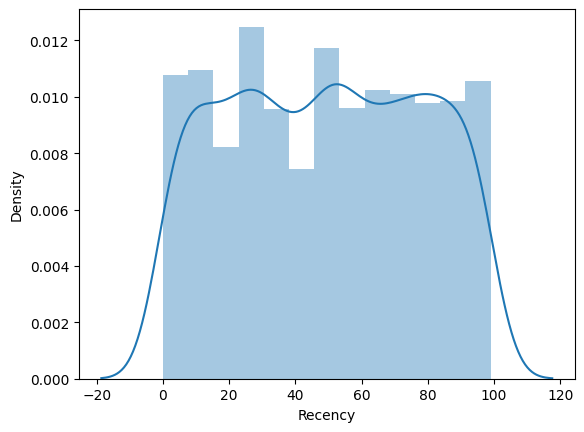

In [ ]:
#cek visualisasi data Recency

sns.distplot(customer['Recency'])

In [ ]:
#Mengubah data Recency menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data
#saya mengisi nilai yang Nan saat dilakukan operasi dengan 'unknown'

customer['Recency'] = pd.cut(customer['Recency'], bins=[0 , 40 , 60 ,80 , 100 , 120], labels=['0 - 39', '40 - 59', '60 - 79', '80 - 99', '100+'])
customer['Recency'] = customer['Recency'].cat.add_categories('Unknown').fillna('Unknown')

In [ ]:
#cek data customer

customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,40 - 59,8,4,7,40000 - 59999,11,60 - 79
1,2174,Graduation,0 - 39,1,2,5,40000 - 59999,9,60 - 79
2,4141,Graduation,0 - 39,8,10,4,60000 - 79999,10,40 - 59
3,6182,Graduation,0 - 39,2,4,6,20000 - 39999,9,20 - 39
4,5324,PhD,80 - 99,5,6,5,40000 - 59999,9,40 - 59


In [ ]:
#cek nilai unik pada kolom Recency

customer.Recency.unique()

['40 - 59', '0 - 39', '80 - 99', '60 - 79', 'Unknown']
Categories (6, object): ['0 - 39' < '40 - 59' < '60 - 79' < '80 - 99' < '100+' < 'Unknown']

<ipython-input-36-08a731b57bbf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['NumWebPurchases'])


<Axes: xlabel='NumWebPurchases', ylabel='Density'>

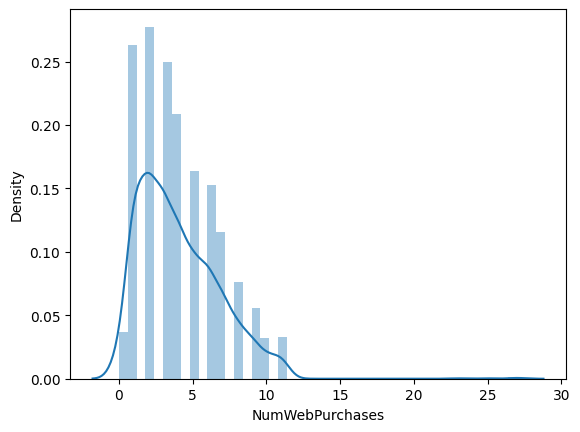

In [ ]:
#cek visualisasi data NumWebPurchases

sns.distplot(customer['NumWebPurchases'])

In [ ]:
##Mengubah data NumWebPurchases menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data
#saya mengisi nilai yang Nan saat dilakukan operasi dengan 'unknown'

customer['NumWebPurchases'] = pd.cut(customer['NumWebPurchases'], bins=[0 , 10 , 15 ,  20 , 25], labels=['0 - 9', '  10 - 14', '15 - 19', '20+'])
customer['NumWebPurchases'] = customer['NumWebPurchases'].cat.add_categories('Unknown').fillna('Unknown')

In [ ]:
customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,40 - 59,0 - 9,4,7,40000 - 59999,11,60 - 79
1,2174,Graduation,0 - 39,0 - 9,2,5,40000 - 59999,9,60 - 79
2,4141,Graduation,0 - 39,0 - 9,10,4,60000 - 79999,10,40 - 59
3,6182,Graduation,0 - 39,0 - 9,4,6,20000 - 39999,9,20 - 39
4,5324,PhD,80 - 99,0 - 9,6,5,40000 - 59999,9,40 - 59


In [ ]:
##cek nilai unik data NumWebPurchases

customer.NumWebPurchases.unique()

['0 - 9', '  10 - 14', 'Unknown', '20+']
Categories (5, object): ['0 - 9' < '  10 - 14' < '15 - 19' < '20+' < 'Unknown']

<Axes: >

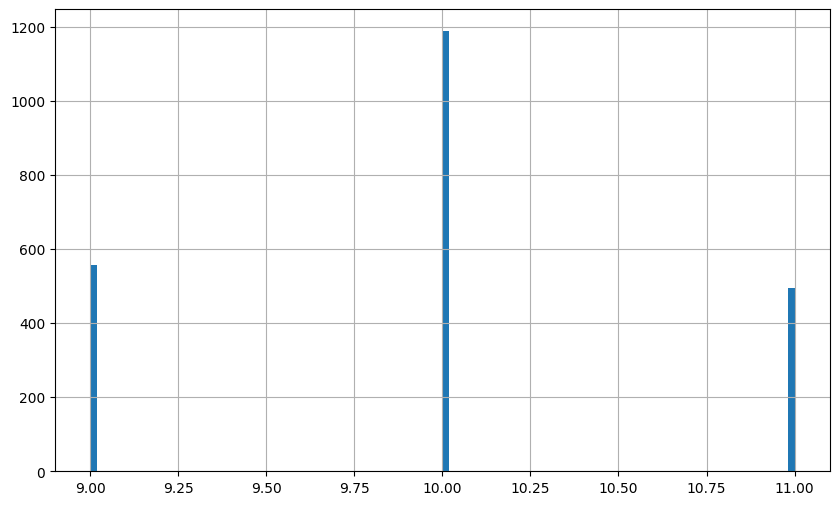

In [ ]:
plt.figure(figsize=(10,6))
customer['Years_Since_Registration'].hist(bins=100)

In [ ]:
##Mengubah data Years_Since_Registration menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data
#saya mengisi nilai yang Nan saat dilakukan operasi dengan 'unknown'

customer['Years_Since_Registration'] = pd.cut(customer['Years_Since_Registration'], bins= [8.5 , 9 , 9.75 , 10 , 11] , labels=['8.5- 8.9 ', '9 - 9.9' ,'10-10.9' , '11+'])
customer['Years_Since_Registration'] = customer['Years_Since_Registration'].cat.add_categories('Unknown').fillna('Unknown')

In [ ]:
customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,40 - 59,0 - 9,4,7,40000 - 59999,11+,60 - 79
1,2174,Graduation,0 - 39,0 - 9,2,5,40000 - 59999,8.5- 8.9,60 - 79
2,4141,Graduation,0 - 39,0 - 9,10,4,60000 - 79999,10-10.9,40 - 59
3,6182,Graduation,0 - 39,0 - 9,4,6,20000 - 39999,8.5- 8.9,20 - 39
4,5324,PhD,80 - 99,0 - 9,6,5,40000 - 59999,8.5- 8.9,40 - 59


<Axes: >

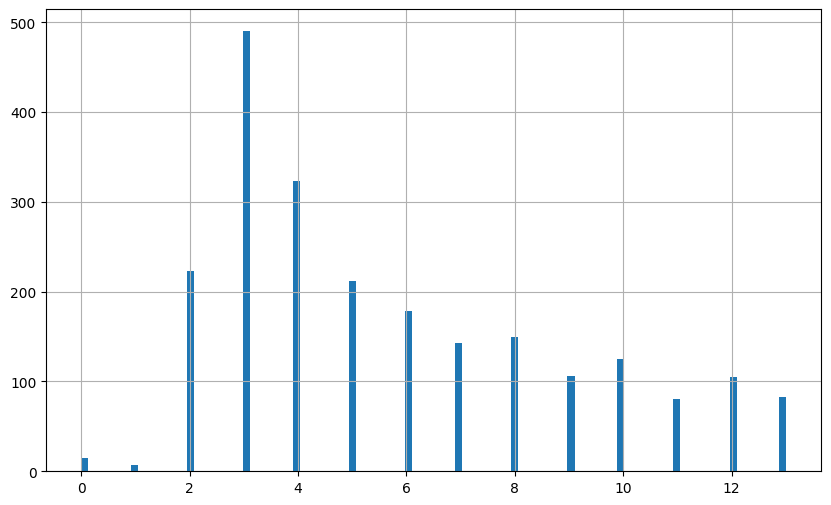

In [ ]:
#Melihat Visualisasi data NumStorePurchases dengan menggunakan histogram

plt.figure(figsize=(10,6))
customer['NumStorePurchases'].hist(bins=100)

In [ ]:
##Mengubah data NumStorePurchases menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data
#saya mengisi nilai yang Nan saat dilakukan operasi dengan 'unknown'

customer['NumStorePurchases'] = pd.cut(customer['NumStorePurchases'], bins= [0 , 4  , 8 , 10, 12] , labels=['0 - 3' , '4 - 7' , '8 - 9', '10+'  ])
customer['NumStorePurchases'] = customer['NumStorePurchases'].cat.add_categories('Unknown').fillna('Unknown')

In [ ]:
customer.NumStorePurchases.unique()

['0 - 3', '8 - 9', '4 - 7', 'Unknown', '10+']
Categories (5, object): ['0 - 3' < '4 - 7' < '8 - 9' < '10+' < 'Unknown']

<ipython-input-46-c7d57d0faac3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['NumWebVisitsMonth'])


<Axes: xlabel='NumWebVisitsMonth', ylabel='Density'>

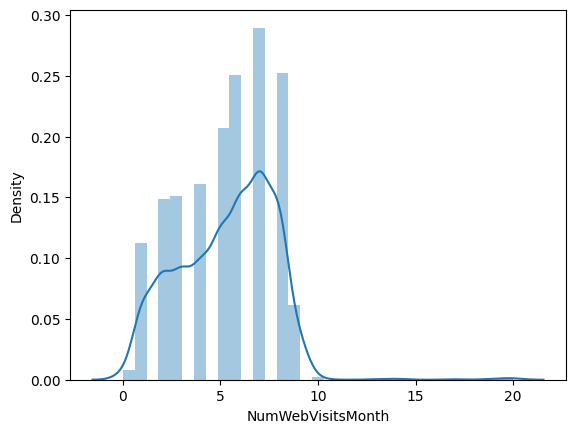

In [ ]:
#Melihat visualisasi data NumWebVistitsMonth dengan menggunakan histogram

sns.distplot(customer['NumWebVisitsMonth'])

In [ ]:
##Mengubah data NumWebVisitsMonth menjadi bentuk kategorikal untuk memudahkan perhitungan jarak antar data
#saya mengisi nilai yang Nan saat dilakukan operasi dengan 'unknown'

customer['NumWebVisitsMonth'] = pd.cut(customer['NumWebVisitsMonth'], bins=[0,10, 19, 20], labels=['0 - 9 ' , '10 - 18' , '19+'])
customer['NumWebVisitsMonth'] = customer['NumWebVisitsMonth'].cat.add_categories('Unknown').fillna('Unknown')

In [ ]:
customer.head()

,ID,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,5524,Graduation,40 - 59,0 - 9,0 - 3,0 - 9,40000 - 59999,11+,60 - 79
1,2174,Graduation,0 - 39,0 - 9,0 - 3,0 - 9,40000 - 59999,8.5- 8.9,60 - 79
2,4141,Graduation,0 - 39,0 - 9,8 - 9,0 - 9,60000 - 79999,10-10.9,40 - 59
3,6182,Graduation,0 - 39,0 - 9,0 - 3,0 - 9,20000 - 39999,8.5- 8.9,20 - 39
4,5324,PhD,80 - 99,0 - 9,4 - 7,0 - 9,40000 - 59999,8.5- 8.9,40 - 59


In [ ]:
#membuang kolom Id karena tidak digunakan saat melakukan Clustering

customer.drop(columns=['ID'], inplace=True)

In [ ]:
#Cek data setelah pembuangan kolom ID

customer.head(3)

,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age
0,Graduation,40 - 59,0 - 9,0 - 3,0 - 9,40000 - 59999,11+,60 - 79
1,Graduation,0 - 39,0 - 9,0 - 3,0 - 9,40000 - 59999,8.5- 8.9,60 - 79
2,Graduation,0 - 39,0 - 9,8 - 9,0 - 9,60000 - 79999,10-10.9,40 - 59


In [ ]:
#cek kembali nilai kosong pada data

customer.isna().sum()

Education                   0
Recency                     0
NumWebPurchases             0
NumStorePurchases           0
NumWebVisitsMonth           0
Income                      0
Years_Since_Registration    0
Age                         0
dtype: int64

###Modelling

In [ ]:
!pip install kmodes

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
#menentukan jumlah cluster yang optimal untuk data dengan membagi data ke jumlah cluster yang berbeda, dari 1 - 1o
#Menghitung nilai cost untuk setiap jumlah cluster.
#Memilih jumlah cluster dengan nilai cost yang paling rendah.

cost = []
K = range(1,10)

for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init='random', n_init=5, verbose=1)
    kmode.fit_predict(customer)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 7380.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 7380.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 7380.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 7380.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 7380.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 206, cost: 6352.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 310, cost: 6453.0
Run 2, iteration: 2/100, moves: 86, cost: 6453.0
Init: initializing centroids


Text(0.5, 0, 'Num of Clusters')

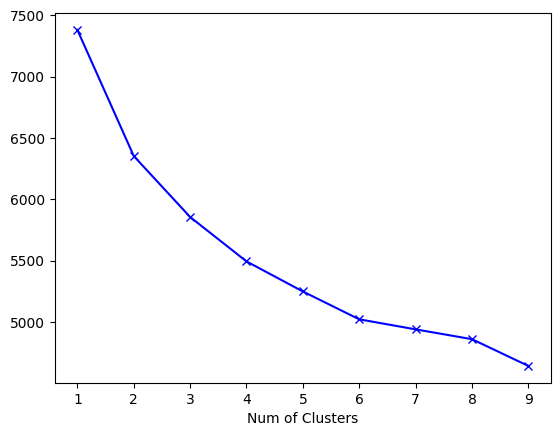

In [ ]:
#melakukan visualisasi num_cluster

plt.plot(K, cost, 'bx-')
plt.xlabel('Num of Clusters')

In [ ]:
# melakukan modeling ulang
# saya memutuskan untuk membagi cluster menjadi 5 cluster

kmode = KModes(n_clusters=5, init='random', n_init=5, verbose=1, random_state=42)
clusters = kmode.fit_predict(customer)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 554, cost: 5391.0
Run 1, iteration: 2/100, moves: 23, cost: 5391.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 622, cost: 5370.0
Run 2, iteration: 2/100, moves: 234, cost: 5370.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 536, cost: 5433.0
Run 3, iteration: 2/100, moves: 125, cost: 5433.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 287, cost: 5521.0
Run 4, iteration: 2/100, moves: 221, cost: 5521.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 785, cost: 5339.0
Best run was number 5


In [ ]:
#membuat kolom baru pada customer yang berisi nilai Cluster

customer['Cluster'] = clusters

In [ ]:
customer.head()

,Education,Recency,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Years_Since_Registration,Age,Cluster
0,Graduation,40 - 59,0 - 9,0 - 3,0 - 9,40000 - 59999,11+,60 - 79,1
1,Graduation,0 - 39,0 - 9,0 - 3,0 - 9,40000 - 59999,8.5- 8.9,60 - 79,1
2,Graduation,0 - 39,0 - 9,8 - 9,0 - 9,60000 - 79999,10-10.9,40 - 59,0
3,Graduation,0 - 39,0 - 9,0 - 3,0 - 9,20000 - 39999,8.5- 8.9,20 - 39,2
4,PhD,80 - 99,0 - 9,4 - 7,0 - 9,40000 - 59999,8.5- 8.9,40 - 59,3


In [ ]:
#mengecek deskripsi data cluster

cluster_summary = customer.groupby('Cluster').describe()
cluster_summary

Education                         Recency                       \
            count unique         top freq   count unique      top freq   
Cluster                                                                  
0             734      5  Graduation  447     734      5  40 - 59  237   
1             523      5         PhD  226     523      5   0 - 39  271   
2             495      5  Graduation  365     495      5  40 - 59  161   
3             308      4  Graduation  218     308      4   0 - 39  191   
4             180      4         PhD   96     180      3   0 - 39  144   

        NumWebPurchases         ...         Income       \
                  count unique  ...            top freq   
Cluster                         ...                       
0                   734      4  ...  60000 - 79999  537   
1                   523      3  ...  40000 - 59999  298   
2                   495      2  ...  20000 - 39999  374   
3                   308      3  ...  40000 - 59999  249   
4                   180      3  ...  20000 - 39999  132   

        Years_Since_Registration                        Age                  \
                           count unique      top freq count unique      top   
Cluster                                                                       
0                            734      3  10-10.9  381   734      4  40 - 59   
1                            523      3  10-10.9  284   523      5  60 - 79   
2                            495      3  10-10.9  268   495      4  40 - 59   
3                            308      3  10-10.9  166   308      3  40 - 59   
4                            180      3  10-10.9   90   180      2  40 - 59   

              
        freq  
Cluster       
0        406  
1        351  
2        352  
3        224  
4        154  

[5 rows x 32 columns]

In [ ]:
#menghitung frekuensi kemunculan data education di cluster 4
customer[customer['Cluster']==4]['Education'].value_counts()

PhD         96
Master      38
2n Cycle    31
Basic       15
Name: Education, dtype: int64

##b. Informasi Karakteristik Pelanggan pada Tiap Cluster


*   Cluster 0 :  Sarjana berusia 40 - 59 tahun dengan Range Income sebesar 60000 - 79999 dan besaran recency sebesar 40 - 59  yang memiliki total pembelian Web sebanyak 0-9 buah dan Jumlah pembelian Toko dengan range  4 - 7 serta berkunjung setiap bulan sebanyak 0-9 kali dan sudah 10 tahun lebih dari sekarang sejak pertama melakukan registrasi.
*   Cluster 1 : Seorang dengan Gelar phD yang berusia 60 - 79 tahun dengan Range Income sebesar 40000 - 59999	dan besaran recency sebesar 0 - 39 yang mempunyai jumlah pembelian web sebanyak 0 - 9 dan jumlah pembelian Toko dengan range 0 -3 serta berkunjung 0 - 9 kali setiap bulan dan sudah 10 tahun lebih dari sekarang sejak pertama kali melakukan registrasi.

*   Cluster 2 : Seorang Sarjana berusia 40 - 59 tahun dengan Range Income sebesar 20000 - 39999	dan besaran rencency sebanyak 40 - 59 yang memiliki total pembelian web sejumlah 0 -9 buah dan jumlah pembelian Toko dengan Range 0 - 3 serta berkunjung 0 - 9 kali setiap bulan dan sudah 10 tahun lebih dari sekarang sejak pertama kali melakukan registrasi.
*   Cluster 3 : Seorang Sarjana berusia 40 - 59 tahun dengan Range Income sebesar 40000 - 59999	dan besaran recency sebanyak 0 - 39 yang memiliki total pembelian web sejumlah 0 - 9 buah dan jumlah pembelian toko dengan Range 4 - 7 serta berkunjung  ke web 0 - 9 kali setiap bulannya dan sudah 10 tahun lebih dari sekarang sejak pertama kali melakukan registrasi.
*   Cluster 4 : Seorang PhD berusia 40 - 59 tahun dengan Range Income Sebesar  20000 - 39999	dan besaran recency sebanyak 0 - 39 yang memiliki total pembelian web sejumlah 0 - 9 buah dan jumlah pembelian toko dengan Range 0 -3 serta berkunjung ke web 0 - 9 kali setiap bulannya dan sudah 10 tahun lebih dari sekarang sejak pertama kali melakukan registrasi.







**Insight**



*  dari percobaan yang dilakukan, didapat 5 buah cluster yang berbeda berdasarkan berbagai karakteristik seperti Usia,recency,pendapatan,dan frekuensi pembelian
*   Customer yang ada terbagi atas 5 jenis berdasarkan riwayat pendidikan yang dimiliki seperti Graduation , PhD , 2n Cycle ,Basic , dan Master

*   Pelanggan dengan Riwayat Pendidikan Graduation/Sarjana menempati bagian  teratas di 3 Cluster dari total 5 cluster yang ada yakni pada Cluster 0, 2 , dan 3








**Rekomendasi**


*   pelayanan dan tawaran Produk bisa disesuaikan kembali untuk masing- masing kelompok sehingga bisa meningkatkan retensi dan kepuasan dari pelanggan.

* Sepertinya perlu dipertimbangkan untuk menawarkan program loyalitas ataupun insentif agar dapat mempertahankan tingkat pembelian dan kunjungan pelanggan terkhusus pelanggan pada cluster 0 dan 3
* untuk pelanggan pada Cluster 1,2, dan 4 perlu dipertimbangkan untuk menawarkan tawaran dengan harga yang lebih terjangkau atau bisa juga dengan memberikan promosi yang menarik yang dapat disesuaikan dengan Usia pelanggan di tiap Cluster sehingga bisa memancing mereka untuk membeli lebih banyak atau lebih sering lagi.






##Dataset Laptop

In [ ]:
#cek data laptop

laptop.head(5)

,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,Apple,Ultrabook,8,1.37,11.175755,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,10.776777,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,10.329931,0,0,141.211998,Intel Core i5,0,256,Intel,Others
3,Apple,Ultrabook,16,1.83,11.814476,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,11.473101,0,1,226.983005,Intel Core i5,0,256,Intel,Mac


In [ ]:
#mengecek informasi yang ada pada tabel laptop

laptop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1273 non-null   object 
 1   TypeName     1273 non-null   object 
 2   Ram          1273 non-null   int64  
 3   Weight       1273 non-null   float64
 4   Price        1273 non-null   float64
 5   TouchScreen  1273 non-null   int64  
 6   Ips          1273 non-null   int64  
 7   Ppi          1273 non-null   float64
 8   Cpu_brand    1273 non-null   object 
 9   HDD          1273 non-null   int64  
 10  SSD          1273 non-null   int64  
 11  Gpu_brand    1273 non-null   object 
 12  Os           1273 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 129.4+ KB


In [ ]:
#mengecek nilai yang kosong pada tabel
laptop.isnull().sum()

Company        0
TypeName       0
Ram            0
Weight         0
Price          0
TouchScreen    0
Ips            0
Ppi            0
Cpu_brand      0
HDD            0
SSD            0
Gpu_brand      0
Os             0
dtype: int64

###Cek Duplikat

In [ ]:
#Mengecek data duplikat

print(f"terdapat {laptop.duplicated().sum()} data duplikat")

terdapat 1 data duplikat


In [ ]:
#Menghapus data duplikat

laptop = laptop.drop_duplicates().reset_index(drop=True)

In [ ]:
# Mengecek kembali data duplikat
print(f"terdapat {laptop.duplicated().sum()} data duplikat")

terdapat 0 data duplikat


## Cek Outlier

In [ ]:
laptop.head()

,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,Apple,Ultrabook,8,1.37,11.175755,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,10.776777,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,10.329931,0,0,141.211998,Intel Core i5,0,256,Intel,Others
3,Apple,Ultrabook,16,1.83,11.814476,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,11.473101,0,1,226.983005,Intel Core i5,0,256,Intel,Mac


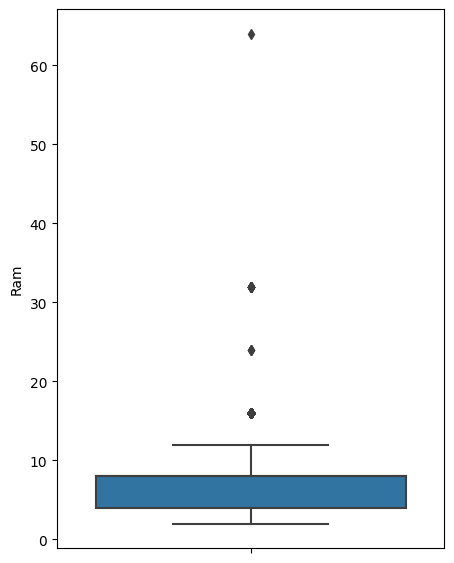

In [ ]:
# mengecek visualisasi data Ram dengan Menggunakan Boxplot

plt.figure(figsize = (5,7))
sns.boxplot(y='Ram',data = laptop)
plt.show()

In [ ]:
#IQR

# membuat sebuah fungsi untuk mengecek Outlier
def periksa_outlier(nama_kolom, batas):
  Q1 = np.percentile(laptop[nama_kolom], 25,
                     interpolation = 'midpoint')

  Q3 = np.percentile(laptop[nama_kolom], 75,
                     interpolation = 'midpoint')

  IQR = Q3 - Q1

#Menentukan Upper Bound
  if batas == 'upper_bound':
      bound = np.where(laptop[nama_kolom] >= (Q3 + 1.5*IQR))

#menentukan Lower Bound
  elif batas == 'lower_bound':
      bound = np.where(laptop[nama_kolom] <= (Q1 - 1.5*IQR))
  return list(bound[0])

In [ ]:
#Menerapkan fungsi yang telah dibuat untuk menghitung berapa jumlah Outlier pada kolom

Upper_Price = periksa_outlier('Price','upper_bound')
Lower_Price = periksa_outlier('Price','lower_bound')

Upper_Ram = periksa_outlier('Ram','upper_bound')
Lower_Ram = periksa_outlier('Ram','lower_bound')

print(f"total outlier dikolom Price adalah {len(Upper_Price) + len(Lower_Price)}")

print(f"total outlier dikolom Ram adalah {len(Upper_Ram) + len(Lower_Ram)}")




total outlier dikolom Price adalah 1
total outlier dikolom Ram adalah 219


In [ ]:
#karena jumlahnya yang sedikit, saya memutuskan untuk mengganti Outlier dengan Median data saja

def isi_outlier(df):
  Q1=df.quantile(0.25)
  Q3=df.quantile(0.75)
  IQR = Q3-Q1

  upper = df[~(df>(Q3+1.5*IQR))].max()
  lower = df[~(df<(Q1-1.5*IQR))].min()

  df = np.where(df > upper,

                df.median(),

                np.where(

                    df < lower,

                    df.median() ,

                    df
                      )
                )
  return df

In [ ]:
#Saya memutuskan untuk mengisi ketiga data tersebut dengan Medianya, karena saya rasa data tersebut cukup berharga
#Menggunakan Function isi_outlier untuk mengisi data Outlier pada ketiga kolom dengan medianya masing-masing


laptop['Price'] = isi_outlier(laptop['Price'])

laptop['Ram'] = isi_outlier(laptop['Ram'])

laptop['Weight'] = isi_outlier(laptop['Weight'])



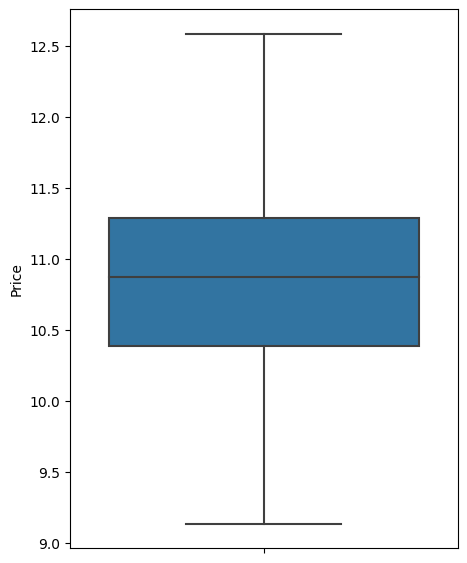

In [ ]:
#Cek Outlier kolom Price dengan bantuan Boxplot
plt.figure(figsize = (5,7))
sns.boxplot(y='Price',data = laptop)
plt.show()

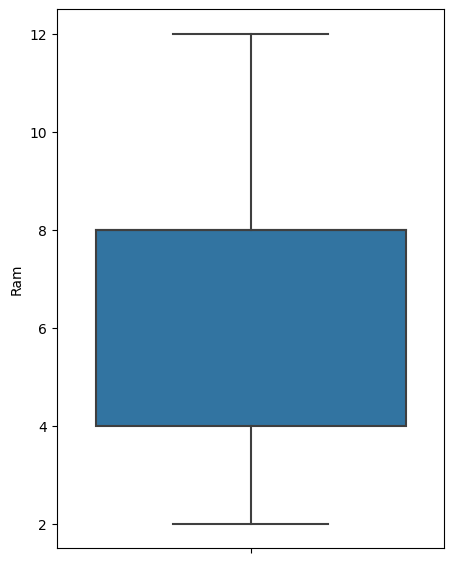

In [ ]:
#Cek Outlier pada Kolom  Ram dengan bantuan Boxplot

plt.figure(figsize = (5,7))
sns.boxplot(y='Ram',data = laptop)
plt.show()

In [ ]:
#mengubah tipe data Kolom Ram menjadi Integer

laptop['Ram'] = laptop['Ram'].astype(int)

## a. Informasi spesifikasi yang memengaruhi tinggi rendahnya harga laptop

In [ ]:
#melakukan pencarian variabel data selain price memiliki korelasi paling kuat dengan price menggunakan corr()
# Kolom data SSD dan Ram memiliki korelasi yang paling kuat dengan variabel Price

laptop.corr()['Price'].sort_values()

<ipython-input-76-2b4888b84881>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  laptop.corr()['Price'].sort_values()


HDD           -0.095650
Weight        -0.039698
TouchScreen    0.189551
Ips            0.281926
Ppi            0.476524
SSD            0.651212
Ram            0.664761
Price          1.000000
Name: Price, dtype: float64

In [ ]:
#menggunakan Ordinary Least Square (OLS)
# saya hanya menggunakan data yang saya rasa memiliki korelasi yang cukup kuat dengan price dari hasil perhitungan korelasi yang telah dilakukan sebelumnya

model_1 = sm.ols(formula = 'Price ~ Ram + SSD + Ppi + Ips', data=laptop).fit()

In [ ]:
#melihat summary dari model yang telah dibuat
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     517.3
Date:                Fri, 27 Oct 2023   Prob (F-statistic):          1.71e-264
Time:                        10:33:30   Log-Likelihood:                -575.58
No. Observations:                1272   AIC:                             1161.
Df Residuals:                    1267   BIC:                             1187.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3627      0.051    185.222      0.0


*   H0 = Variabel Independen kurang memengaruhi variabel Dependen
*   H1 =Variabel independen mempunyai pengaruh signifikan terhadap Variabel Dependen


dari hasil summary diatas terlihat bahwa nilai P Value dari Ram, SSD, Ppi, dan Ips semuanya < 0.05 yang artinya bahwa seluruh kolom spesifikasi data/ Variabel Independen tersebut memengaruhi terhadap tinggi rendahnya harga laptop.

### Memprediksi harga laptop berdasarkan spesifikasi

Membuat Pemodelan untuk memprediksi harga laptop

In [ ]:
# coba menggunakan variabel Ram

X = laptop[['Ram']]
Y = laptop['Price']
lr = LinearRegression()
lr.fit(X,Y)
lr.score(X,Y)

0.4419068408178354

dari hasil tersebut terlihat bahwa Kolom Ram yang memiliki korelasi paling tinggi dapat menjelaskan Price sebesar 44%

In [ ]:
spesifikasi = ["Ram","SSD","Ppi","Ips"]

In [ ]:
#menghitung nilai R Square

x = laptop[spesifikasi]
y = laptop.Price
lr.fit(x,y)
lr.score(x,y)


0.6202143241196639

In [ ]:
# menggunakan standardScaler guna memastikan bahwa semua spesifikasi memiliki skala yang sama
# membuat bentuk polinomial dari fitur yang ada untuk menemukan hubungan yang lebih kompleks antar spesifikasi yang ada
# melakukan pemodelan regresi

input =[('scale',StandardScaler()),('polynomial', PolynomialFeatures(include_bias = False)), ('model',LinearRegression())]

In [ ]:
#melakukan pelatihan sekaligus evaluasi kinerja model terhadap data

x = laptop[spesifikasi]
y = laptop.Price
pipe = Pipeline(input)
pipe.fit(x,y)
pipe.score(x,y)

0.6506673805284611

In [ ]:
#mengimport metode yang digunakan  untuk membagi data menjadi data untuk pelatihan & pengujian

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
#melakukan pembagian data dengan 15% data sebagai pengujian & 85% sisanya sebagai data untuk pelatihan

spesifikasi = ["Ram","SSD","Ppi","Ips"]
x = laptop[spesifikasi]
y = laptop['Price']

x_train, x_test , y_train , y_test = train_test_split(x,y, test_size = 0.15, random_state=1)

print('jumlah sampel tes : ' , x_test.shape[0])
print('jumlah sampel latihan : ' , x_train.shape[0])

jumlah sampel tes :  191
jumlah sampel latihan :  1081


In [ ]:
#mengimport Ridge untuk mencegah overfitting sehingga model dapat lebih baik dan andal

from sklearn.linear_model import Ridge

In [ ]:
#melakukan pengukuran terhadap kinerja model regresi Ridge pada kedua pembagian data

rm=Ridge(alpha=0.1)
rm.fit(x_train,y_train)
rm.score(x_test,y_test)

0.6420490842661521

In [ ]:
# Melakukan penggabungan  fitur polinomialn sekaligus mengukur kinerja dari model regresi pada data penguujia untuk memprediksi nilai dari target yang diberikan

pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train)
x_test_pr=pr.fit_transform(x_test)
rr=Ridge(alpha=0.1)
rr.fit(x_train_pr,y_train)
rr.score(x_test_pr,y_test)

0.6771346343977522

Mulai memprediksi harga laptop sesuai spesifikasi

In [ ]:
#melakukan prediksi harga laptop dengan spesifikasi tertentu
#misal laptop dengan spesifikasi Ram =  8 , SSD = 512 , Ppi =  141.211998 , Ips = 1

new_laptop_specifications = np.array([[8, 512, 141.211998, 1]])
new_laptop_specifications_pr = pr.transform(new_laptop_specifications)
predicted_price = rr.predict(new_laptop_specifications_pr)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [ ]:
# Hasil Prediksi Harga dari spesifikasi yang telah diberikan

print(predicted_price)

[11.50040926]


**Insight**


*   Spesifikasi yang paling berpengaruh terhadap tinggi rendahnya harga laptop adalah Ram , SSD , Ips, dan Ppi.
*   Dalam Urutan Prioritas, Ram adalah spesifikasi yang paling berpengaruh terhadap harga suatu laptop, artinya dengan meningkatkan Ram maka akan berdampak cukup signifikan terhadap peningkatan harga laptop.

*  dengan menggunakan model regresi linear, untuk memperoleh prediksi harga dengan spesifikasi tertentu misal Ram = 8  , SSD = 512 , Ppi = 141.211998 , Ips =1 diperoleh prediksi harga sebesar 11.84 jt






**Rekomendasi**



*   Bagi Penjual ataupun Produsen Laptop, dengan analisa ini menunjukkan bahwa dengan meningkatkan Ram , SSD , Ips , dan Ppi pada laptop akan berdampak baik bagi harga jual laptop dan merupakan salah satu strategi untuk peningkatan nilai produk yang dimiliki.
* meningkatkan kapasitas SSD , kualitas layar juga dapat menjadi pertimbangan untuk meningkatkan daya tarik pada produk laptop yang dimiliki, mengingat komponen spesifikasi ini juga sangat dibutuhkan oleh konsumen yang otomatis akan berdampak baik bagi penjualan jika komponen tersebut relevan sesuai dengan pasar yang ada.

